In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import GraphHelpers as GH
import ETFunctions as et
import MathsUtilities as MUte
import math

## Bring in the data needed

In [2]:
root = 'C:\GitHubRepos\CropWaterAnalysis'

In [3]:
WheatBiomass = pd.concat([pd.read_excel(root+'/Wheat/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['Wheat'],names=['Crop'])
BarleyBiomass = pd.concat([pd.read_excel(root+'/Barley/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['Barley'],names=['Crop'])
OatsBiomass = pd.concat([pd.read_excel(root+'/Oats/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['Oats'],names=['Crop'])
FodderBeet = pd.concat([pd.read_excel(root+'/FodderBeet/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['FodderBeet'],names=['Crop'])
LucerneAndPasture = pd.read_excel(root+'/LucerneAndPasture/RawDatafiles/Biomass.xlsx',header=[0,1,2])
SpecLab = LucerneAndPasture.columns.get_level_values(0)
IrriLab = LucerneAndPasture.columns.get_level_values(1)
BlocLab = LucerneAndPasture.columns.get_level_values(2)
NewCols = pd.MultiIndex.from_arrays([SpecLab,
                                     SpecLab,
                                     IrriLab,
                                     SpecLab,
                                     BlocLab], names=['Species','Crop','Irrigation','Nitrogen','Block'])
LucerneAndPasture.columns = NewCols
RyegrassBiomass = LucerneAndPasture.Ryegrass.copy().cumsum()
LucerneBiomass = LucerneAndPasture.Lucerne.copy().cumsum()
Biomass = pd.concat([WheatBiomass,BarleyBiomass,OatsBiomass,FodderBeet,LucerneBiomass,RyegrassBiomass],axis=1)

In [4]:
MetData = pd.read_pickle(root+'\General\BroadfieldsMet\BroadFieldsMet.pkl')
DaylightIndex = MetData.IncomingRadnMJ.where(MetData.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()
MetData.loc[:,'satVP'] = [et.saturated_vapor_pressure(MetData.loc[x,'AirTemperature'])/10 for x in MetData.index]
MetData.loc[:,'VP'] = [MetData.loc[x,'satVP']*MetData.loc[x,'RelativeHumidity']/100 for x in MetData.index]
MetData.loc[:,'VPD'] = MetData.satVP.subtract(MetData.VP)

DailyMet = MetData.IncomingRadnMJ.resample('D').sum()
DailyMet = pd.DataFrame(index=DailyMet.index,data=DailyMet.values,columns=['Radn'])
DailyMet.loc[:,'Temp'] = MetData.AirTemperature.resample('D').mean()
DailyMet.loc[:,'RH'] = MetData.RelativeHumidity.resample('D').mean()
DailyMet.loc[:,'PET'] = [et.Priestly_TaylorEO(DailyMet.loc[x,'Radn'],
                                    DailyMet.loc[x,'Temp'],
                                    1.3,'Total') for x in DailyMet.index]
DailyMet.loc[:,'VPD'] = MetData.loc[DaylightIndex,'VPD'].resample('D').mean()
MinVPD = 0.1
DailyMet.loc[:,'VPD'] = DailyMet.loc[:,'VPD'].where(DailyMet.loc[:,'VPD']>MinVPD,MinVPD)
AccumPET = DailyMet.PET.cumsum()

In [5]:
WU = pd.read_pickle('./DataFrames/Transpiration.pkl')

In [6]:
CommonDates = list(set(Biomass.index).intersection(WU.index))
CommonDates.sort()

In [32]:
WU.Barley.dropna(how='all')

Irrigation       Dash                                                     \
Nitrogen         High                            Low                       
Block               1         3          4         1         3         4   
2014-11-06   0.000000  0.000000   0.000000  0.000000 -0.006390 -0.099658   
2014-11-07   0.000000 -0.258711  -0.425230  0.000000  0.000000 -0.173058   
2014-11-08  -0.038497 -0.313187  -0.510256  0.000000  0.000000 -0.220457   
2014-11-09  -0.520185 -0.067133  -0.631858 -0.403177 -0.275822 -0.298601   
2014-11-10  -1.470748 -0.473945  -0.355472 -0.088492  0.000000 -0.153839   
2014-11-11  -1.145006 -2.388493  -2.118638  0.000000  0.000000  0.000000   
2014-11-12  -0.572110 -0.870038  -0.484937 -0.375013 -0.110847  0.000000   
2014-11-13  -0.650946 -1.114114  -0.612788 -0.854976 -0.953060 -1.738486   
2014-11-14  -0.734820 -0.660673  -1.001403 -1.199416 -0.417083 -0.764022   
2014-11-15  -1.499635 -1.238637  -1.621873 -1.309172 -0.718572 -1.472616   
2014-11-16  -1.573787 -0.879972  -1.481076 -1.195072 -0.994316 -1.013438   
2014-11-17  -3.053323 -0.893825  -2.071636 -2.015659 -1.385255 -1.486876   
2014-11-18   0.000000 -1.126819   0.000000 -1.673308 -1.950464 -1.406492   
2014-11-19  -2.071496 -3.992220  -2.975077 -4.093149 -2.866210 -2.563749   
2014-11-20  -2.360069 -3.353231  -3.304233 -3.543636 -3.152551 -3.111457   
2014-11-21  -4.486107 -4.731688  -4.518349 -3.977917 -1.987316 -2.115649   
2014-11-22  -4.108893 -3.446824  -4.219753 -2.600849 -1.640116 -1.888633   
2014-11-23  -4.859330 -3.673123  -5.582063 -2.613848 -1.930545 -1.949105   
2014-11-24  -6.704566 -6.116412  -5.646356 -3.975202 -3.132157 -3.231226   
2014-11-25  -1.461676 -2.656569  -2.504545 -3.015564 -1.283635 -0.973246   
2014-11-26  -4.595870 -5.170708  -4.333403 -4.954301 -2.796036 -2.560994   
2014-11-27  -5.235101 -6.270772  -4.530675 -3.836441 -2.004120 -2.452209   
2014-11-28  -0.868031 -1.129879  -0.748798 -1.342248 -0.652543 -0.565267   
2014-11-29  -5.510707 -5.448576  -4.265618 -2.950477 -2.055452 -2.076511   
2014-11-30  -4.439614 -3.788709  -3.793335 -2.453254 -1.162555 -1.522714   
2014-12-01  -5.754868 -3.769305  -2.944976 -3.754212 -1.664435 -1.558887   
2014-12-02  -3.995865 -3.746631  -1.747575 -2.225294 -1.568416 -2.727906   
2014-12-03  -3.443405 -4.077450  -3.234532 -0.915466 -0.681888 -2.378340   
2014-12-04  -2.300270 -3.067497  -2.672147 -0.425558 -1.450151 -1.155985   
2014-12-05  -2.854270 -3.144291  -3.137392 -1.767343 -2.645873 -2.453266   
...               ...       ...        ...       ...       ...       ...   
2015-01-13  -4.573672 -2.262540  -4.346011 -3.152283 -1.928195 -2.694568   
2015-01-14  -2.374365 -1.173997  -2.467575 -2.336497 -1.095860 -1.723913   
2015-01-15  -5.539887 -4.525340  -5.788045 -2.670514 -0.932754 -1.203957   
2015-01-16  -9.271235 -6.265883  -9.615288 -4.516008 -3.593204 -2.689272   
2015-01-17 -10.426814 -6.335223 -10.894035 -4.237272 -2.922430 -3.066712   
2015-01-18 -13.579138 -6.170600 -12.751948 -3.167992 -1.203826 -1.862208   
2015-01-19 -13.481276 -4.684643 -12.602874 -1.745383 -0.483980 -1.283712   
2015-01-20  -6.359142 -2.862186  -6.885907 -0.467034 -0.157972 -0.618201   
2015-01-21  -3.555288 -1.654187  -3.484187 -0.686687 -0.236946 -0.345437   
2015-01-22  -7.886697 -3.573915  -7.425859 -1.559137 -0.549359 -0.786637   
2015-01-23  -6.901566 -3.013221  -6.962336 -0.480967 -0.456402 -0.530262   
2015-01-24  -5.483404 -2.469351  -5.561499 -1.205319 -0.178209 -0.557819   
2015-01-25  -4.164685 -2.685346  -5.327765 -0.946652 -0.087559 -0.221652   
2015-01-26  -4.231645 -2.376810  -5.276597 -0.275876 -0.609028 -2.126402   
2015-01-27  -1.552238 -1.276446  -2.590997 -0.636170 -0.185321 -0.648286   
2015-01-28  -1.962464 -1.541305  -3.203542 -0.139670 -0.053197 -0.919275   
2015-01-29  -1.952284 -1.520342  -3.474982 -0.134470 -0.078966 -1.361352   
2015-01-30  -0.686614 -1.076229  -0.586993 -0.162019 -0.164911 -0.532019   
2015-01-31  -1.337715 -1.212271  -2.203539 -0.40

In [7]:
WU = WU.loc[np.min(CommonDates):,:].dropna(how='all').copy()
AccumulatedWU = WU.cumsum(axis=0).copy() * -1
WUoverVPD = WU.divide(DailyMet.loc[WU.index,'VPD'],axis=0)
AccumWUoverVPD = WUoverVPD.cumsum(axis=0).copy() * -1

In [8]:
SetDate1 = '2012-09-07'
SetDate2 = '2013-07-01'
StartDate2 = '2013-07-02'
FinalDate = '2014-07-01'
AccumSet1 = AccumulatedWU.loc[SetDate1,:].copy()
AccumSet2 = AccumulatedWU.loc[SetDate2,:].copy()
AccumulatedWU.loc[SetDate1:SetDate2,'Lucerne'] = AccumulatedWU.loc[SetDate1:SetDate2,'Lucerne'].subtract(AccumSet1.Lucerne,axis=1).values
AccumulatedWU.loc[StartDate2:FinalDate,'Lucerne'] = AccumulatedWU.loc[StartDate2:FinalDate,'Lucerne'].subtract(AccumSet2.Lucerne,axis=1).values
AccumulatedWU.loc[SetDate1:SetDate2,'Ryegrass'] = AccumulatedWU.loc[SetDate1:SetDate2,'Ryegrass'].subtract(AccumSet1.Ryegrass,axis=1).values
AccumulatedWU.loc[StartDate2:FinalDate,'Ryegrass'] = AccumulatedWU.loc[StartDate2:FinalDate,'Ryegrass'].subtract(AccumSet2.Ryegrass,axis=1).values

AccumSet1 = AccumWUoverVPD.loc[SetDate1,:].copy()
AccumSet2 = AccumWUoverVPD.loc[SetDate2,:].copy()
AccumWUoverVPD.loc[SetDate1:SetDate2,'Lucerne'] = AccumWUoverVPD.loc[SetDate1:SetDate2,'Lucerne'].subtract(AccumSet1.Lucerne,axis=1).values
AccumWUoverVPD.loc[StartDate2:FinalDate,'Lucerne'] = AccumWUoverVPD.loc[StartDate2:FinalDate,'Lucerne'].subtract(AccumSet2.Lucerne,axis=1).values
AccumWUoverVPD.loc[SetDate1:SetDate2,'Ryegrass'] = AccumWUoverVPD.loc[SetDate1:SetDate2,'Ryegrass'].subtract(AccumSet1.Ryegrass,axis=1).values
AccumWUoverVPD.loc[StartDate2:FinalDate,'Ryegrass'] = AccumWUoverVPD.loc[StartDate2:FinalDate,'Ryegrass'].subtract(AccumSet2.Ryegrass,axis=1).values

SetDate1 = '2012-07-01'
AccumSet1 = Biomass.loc[SetDate1,:].copy()
AccumSet2 = Biomass.loc[SetDate2,:].copy()
Biomass.loc[SetDate1:SetDate2,'Lucerne'] = Biomass.loc[SetDate1:SetDate2,'Lucerne'].subtract(AccumSet1.Lucerne,axis=1).values
Biomass.loc[StartDate2:FinalDate,'Lucerne'] = Biomass.loc[StartDate2:FinalDate,'Lucerne'].subtract(AccumSet2.Lucerne,axis=1).values
Biomass.loc[SetDate1:SetDate2,'Ryegrass'] = Biomass.loc[SetDate1:SetDate2,'Ryegrass'].subtract(AccumSet1.Ryegrass,axis=1).values
Biomass.loc[StartDate2:FinalDate,'Ryegrass'] = Biomass.loc[StartDate2:FinalDate,'Ryegrass'].subtract(AccumSet2.Ryegrass,axis=1).values


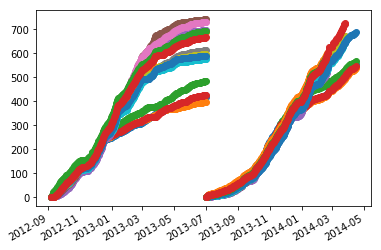

In [9]:
AccumulatedWU.Lucerne.plot(style='o',legend=False)

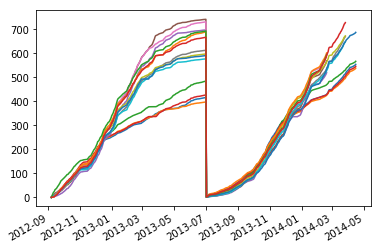

In [10]:
AccumulatedWU.Lucerne.plot(legend=False)

In [11]:
Crops = Biomass.columns.get_level_values(0).drop_duplicates().values
WheatGPs = GH.SetGraphicsPatterns(Biomass.Wheat.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

FodderBeetGPs = GH.SetGraphicsPatterns(Biomass.FodderBeet.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

LucerneGPs = GH.SetGraphicsPatterns(Biomass.loc[:,['Lucerne','Ryegrass']].columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'],InvertLevels=True)

RyegrassGPs = GH.SetGraphicsPatterns(Biomass.loc[:,['Lucerne','Ryegrass']].columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'],InvertLevels=True)

OatsGPs = GH.SetGraphicsPatterns(Biomass.Oats.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['purple','green','orange'])
BarleyGPs = GH.SetGraphicsPatterns(Biomass.Barley.columns,
                    ['--','-'],
                    [0.45,0.15],
                    ['^','o'],
                    ['blue','red','green'])

Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '50', '250']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '250', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 2, 1, 0, 2, 1]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          50    -   green  0.15   o   green
          250   -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          50   --   green  0.45   ^   white
          250  --  purple  0.45   ^   white
Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '50', '300']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '300', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 2, 1, 0, 2, 1]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'ora

In [12]:
def MakeTimeSeriesGraphs(Data,name,ymin,ymax=None):
    Graph = plt.figure(figsize=(18,30))
    Crops = Data.columns.get_level_values(0).drop_duplicates().values
    pos = 1
    for C in Crops:
        GP = globals()[C+'GPs']
        ax = Graph.add_subplot(3,2,pos)
        plt.title(C, fontsize=28)
        GH.AddIndexedPlot(Data.reindex(CommonDates).loc[:,C].dropna(how='all'),ax,GP,2)
        plt.ylabel(name, fontsize=36);
        plt.ylim(ymin,ymax)
        plt.tick_params(labelsize=20)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=int(np.ceil(Data.loc[:,C].dropna(how='all').index.size/30/5))))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
        GH.AddLegend(2,16,'')
        pos+=1
def MakeSingleCropTimeSeries(Data,Crop):
    graph = plt.figure(figsize=(18,18))
    ax = graph.add_subplot(1,1,1)
    GP = globals()[Crop+'GPs']
    GH.AddIndexedPlot(Data.reindex(CommonDates).loc[:,Crop].dropna(how='all'),ax,GP,2)

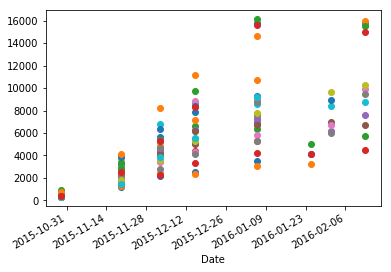

In [13]:
Biomass.Wheat.plot(style = 'o',legend=False)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


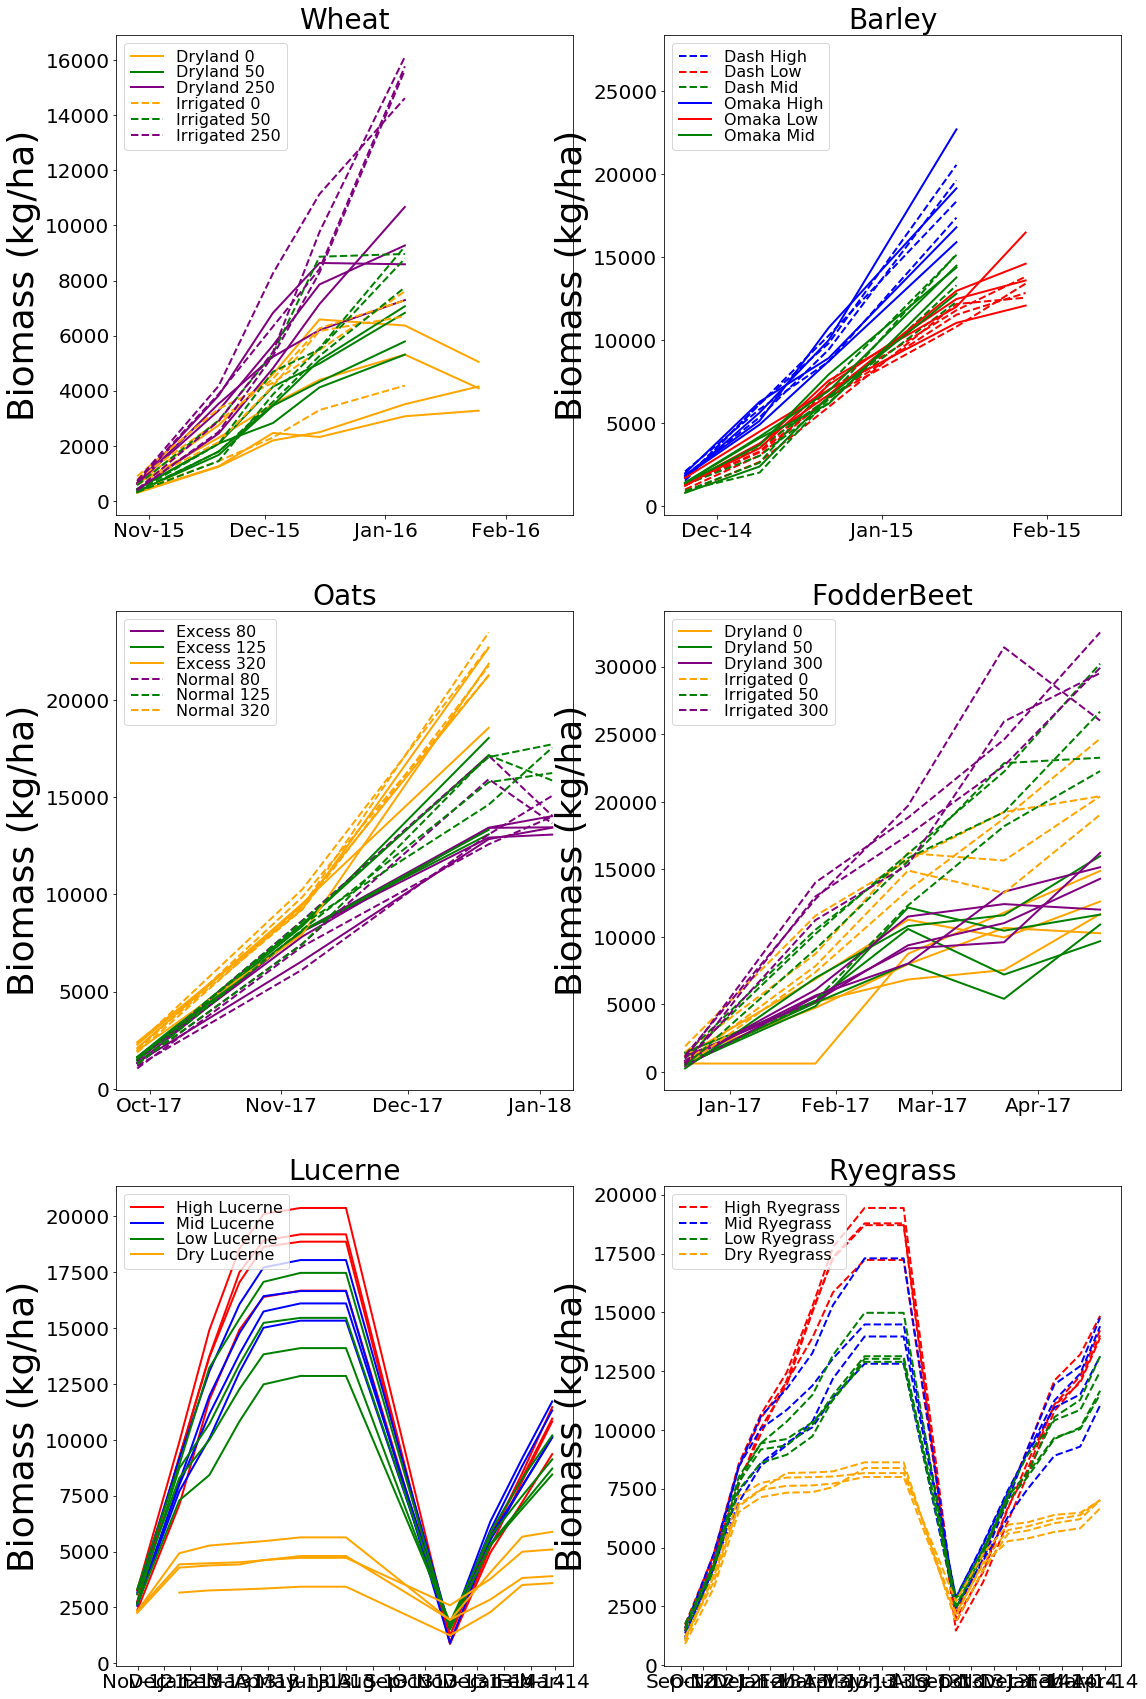

In [14]:
MakeTimeSeriesGraphs(Biomass,'Biomass (kg/ha)',None,)

In [15]:
Biomass.Ryegrass

Irrigation          High                                            \
Nitrogen        Ryegrass                                             
Block                  1             2             3             4   
Date                                                                 
2011-09-29   3206.222049   2336.894096   2796.333645   3548.208436   
2011-11-01   6994.187278   6373.045238   6865.055546   7997.885190   
2011-11-30   9409.718464   8248.459920   8620.807719   9918.270519   
2011-12-20  11668.457533  10445.979121  10675.937215  11994.278989   
2012-01-25  14804.470366  13250.659154  13724.508978  15169.704888   
2012-02-29  18877.546137  16691.090674  17011.633531  19142.311480   
2012-04-03  22091.585652  20033.399820  19933.937506  22101.224019   
2012-05-23  24972.285610  22877.737073  22498.315328  24774.934862   
2012-07-01      0.000000      0.000000      0.000000      0.000000   
2012-09-07   1721.630209   1456.267900   1567.397413   1544.475823   
2012-10-16   4690.628927   4732.058729   4576.385171   4553.318749   
2012-10-31           NaN           NaN           NaN           NaN   
2012-11-19   8403.687600   8558.136498   7762.177521   7660.697745   
2012-12-19  10495.321066  10660.015381   9830.067183  10086.509704   
2013-01-23  12026.937692  12433.579822  12101.524078  11893.648100   
2013-02-27  13913.796152  15250.142002  15066.488376  14996.939859   
2013-03-27  15846.257919  17768.944329  17289.440988  17349.282665   
2013-05-09  17227.469687  19438.135695  18706.808585  18784.047671   
2013-07-01  17227.469687  19438.135695  18706.808585  18784.047671   
2013-09-10   2231.840017   1961.725272   1468.540995   1825.580117   
2013-10-17   4516.446496   3955.960488   3527.727280   4033.845244   
2013-10-30           NaN           NaN           NaN           NaN   
2013-11-20   7250.637657   6670.105773   6136.953340   6727.039291   
2013-12-16   9166.260555   8601.799586   8055.347549   8284.366550   
2014-01-22  12104.161862  11050.964472  10804.267903  11085.764539   
2014-02-26  13212.291372  12003.797855  12090.408801  12294.288706   
2014-03-25  14846.088204  13911.205262  14018.927694  14237.401521   
2014-05-02  16695.749611  15945.177140  16082.369961  16088.215423   
2014-11-25           NaN           NaN           NaN           NaN   
2014-12-09           NaN           NaN           NaN           NaN   
2014-12-22           NaN           NaN           NaN           NaN   
2015-01-15           NaN           NaN           NaN           NaN   
2015-01-28           NaN           NaN           NaN           NaN   
2015-02-11           NaN           NaN           NaN           NaN   
2015-10-29           NaN           NaN           NaN           NaN   
2015-11-19           NaN           NaN           NaN           NaN   
2015-12-03           NaN           NaN           NaN           NaN   
2015-12-15           NaN           NaN           NaN           NaN   
2016-01-06           NaN           NaN           NaN           NaN   
2016-01-25           NaN           NaN           NaN           NaN   
2016-02-01           NaN           NaN           NaN           NaN   
2016-02-13           NaN           NaN           NaN           NaN   
2016-12-19           NaN           NaN           NaN           NaN   
2017-01-26           NaN           NaN           NaN           NaN   
2017-02-22           NaN           NaN           NaN           NaN   
2017-03-22           NaN           NaN           NaN           NaN   
2017-04-19           NaN           NaN           NaN           NaN   
2017-05-17           NaN           NaN           NaN           NaN   
2017-09-05           NaN           NaN           NaN           NaN   
2017-09-28           NaN           NaN           NaN           NaN   
2017-11-06           NaN           NaN           NaN           NaN   
2017-12-20           NaN           NaN           NaN           NaN   
2018-01-04           NaN           NaN           NaN           NaN   
2018-01-09

In [16]:
WU.Ryegrass.loc['2014-04-01':,:]

Irrigation       Dry               High                                Low  \
Nitrogen    Ryegrass           Ryegrass                           Ryegrass   
Block              2         3        1         2         3    4         1   
2014-04-01  -1.50956  -1.57266      NaN  -1.78059  -1.54147  NaN  -1.82168   
2014-04-02  -2.63679  -2.74746      NaN  -3.11131  -2.69163  NaN  -3.18323   
2014-04-03  -2.52251  -2.62967      NaN  -2.97696  -2.57509  NaN  -3.04698   
2014-04-04  -3.38483  -3.53036      NaN   -3.9964  -3.45602  NaN  -4.09111   
2014-04-05 -0.603619  -0.62988      NaN -0.712982 -0.616396  NaN -0.730004   
2014-04-06  -0.94312 -0.984152      NaN  -1.11399 -0.962202  NaN  -1.14059   
2014-04-07  -0.46941  -0.48979      NaN  -0.55433 -0.478799  NaN -0.567822   
2014-04-08 -0.616609 -0.608264      NaN -0.703377 -0.629831  NaN -0.669889   
2014-04-09 -0.863066 -0.893486      NaN  -1.01129 -0.881537  NaN  -1.02461   
2014-04-10  -1.15579  -1.15892      NaN   -1.3516  -1.18937  NaN  -1.31596   
2014-04-11 -0.857982 -0.886761      NaN  -1.00907 -0.873472  NaN  -1.01712   
2014-04-12  -1.14015   -1.1857      NaN  -1.34397  -1.15848  NaN  -1.36603   
2014-04-13 -0.895412 -0.897687      NaN  -1.05113 -0.893048  NaN  -0.98895   
2014-04-14  -1.64099  -1.70047      NaN  -1.93272  -1.64761  NaN  -1.91374   
2014-04-15   -2.4124    -2.521      NaN  -2.83496  -2.42781  NaN  -2.86888   
2014-11-06       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-07       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-08       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-09       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-10       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-11       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-12       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-13       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-14       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-15       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-16       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-17       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-18       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-19       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2014-11-20       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
...              ...       ...      ...       ...       ...  ...       ...   
2017-12-06       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-07       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-08       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-09       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-10       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-11       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-12       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-13       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-14       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-15       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-16       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-17       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-18       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-19       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-20       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-21       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-22       NaN       NaN      NaN       NaN       NaN  NaN       NaN   
2017-12-23       NaN  

In [17]:
Biomass.loc[:,'Lucerne']#.dropna(how='all')

Irrigation          High                                            \
Nitrogen         Lucerne                                             
Block                  1             2             3             4   
Date                                                                 
2011-09-29           NaN           NaN           NaN           NaN   
2011-11-01    673.893406   1022.673069    654.268262    961.009691   
2011-11-30           NaN           NaN           NaN           NaN   
2011-12-20   3138.297648   3856.426997   3331.025762   3920.909070   
2012-01-25   5846.870716   7224.100153   6287.361752   6870.202631   
2012-02-29   8477.335550   9891.691461   9111.854932   9835.418025   
2012-04-03           NaN           NaN           NaN           NaN   
2012-05-23   9768.387951  11046.205350   9940.233149  10966.921482   
2012-07-01      0.000000      0.000000      0.000000      0.000000   
2012-09-07           NaN           NaN           NaN           NaN   
2012-10-16           NaN           NaN           NaN           NaN   
2012-10-31   2745.169620   2366.407592   2723.056579   3263.696409   
2012-11-19           NaN           NaN           NaN           NaN   
2012-12-19   9203.855885   7083.197827   9244.729767   9907.177772   
2013-01-23  13753.789618  11793.016680  13701.110907  14919.265569   
2013-02-27  17502.776268  14930.286890  17051.731418  18553.082305   
2013-03-27  18918.299550  16393.507136  18637.714637  20106.978558   
2013-05-09  19198.956019  16679.708902  18870.001907  20379.773647   
2013-07-01  19198.956019  16679.708902  18870.001907  20379.773647   
2013-09-10           NaN           NaN           NaN           NaN   
2013-10-17           NaN           NaN           NaN           NaN   
2013-10-30    917.164239   1221.176120    860.777031   1226.718333   
2013-11-20           NaN           NaN           NaN           NaN   
2013-12-16   5196.779567   5690.365385   4952.568501   5590.140576   
2014-01-22   8144.170982   8290.951884   7209.306624   8504.202150   
2014-02-26  10825.606073  10951.314767   9361.956170  11466.097463   
2014-03-25           NaN           NaN           NaN           NaN   
2014-05-02  11815.050640  11793.195855  10417.920570  12662.368021   
2014-11-25           NaN           NaN           NaN           NaN   
2014-12-09           NaN           NaN           NaN           NaN   
2014-12-22           NaN           NaN           NaN           NaN   
2015-01-15           NaN           NaN           NaN           NaN   
2015-01-28           NaN           NaN           NaN           NaN   
2015-02-11           NaN           NaN           NaN           NaN   
2015-10-29           NaN           NaN           NaN           NaN   
2015-11-19           NaN           NaN           NaN           NaN   
2015-12-03           NaN           NaN           NaN           NaN   
2015-12-15           NaN           NaN           NaN           NaN   
2016-01-06           NaN           NaN           NaN           NaN   
2016-01-25           NaN           NaN           NaN           NaN   
2016-02-01           NaN           NaN           NaN           NaN   
2016-02-13           NaN           NaN           NaN           NaN   
2016-12-19           NaN           NaN           NaN           NaN   
2017-01-26           NaN           NaN           NaN           NaN   
2017-02-22           NaN           NaN           NaN           NaN   
2017-03-22           NaN           NaN           NaN           NaN   
2017-04-19           NaN           NaN           NaN           NaN   
2017-05-17           NaN           NaN           NaN           NaN   
2017-09-05           NaN           NaN           NaN           NaN   
2017-09-28           NaN           NaN           NaN           NaN   
2017-11-06           NaN           NaN           NaN           NaN   
2017-12-20           NaN           NaN           NaN           NaN   
2018-01-04           NaN           NaN           NaN           NaN   
2018-01-09

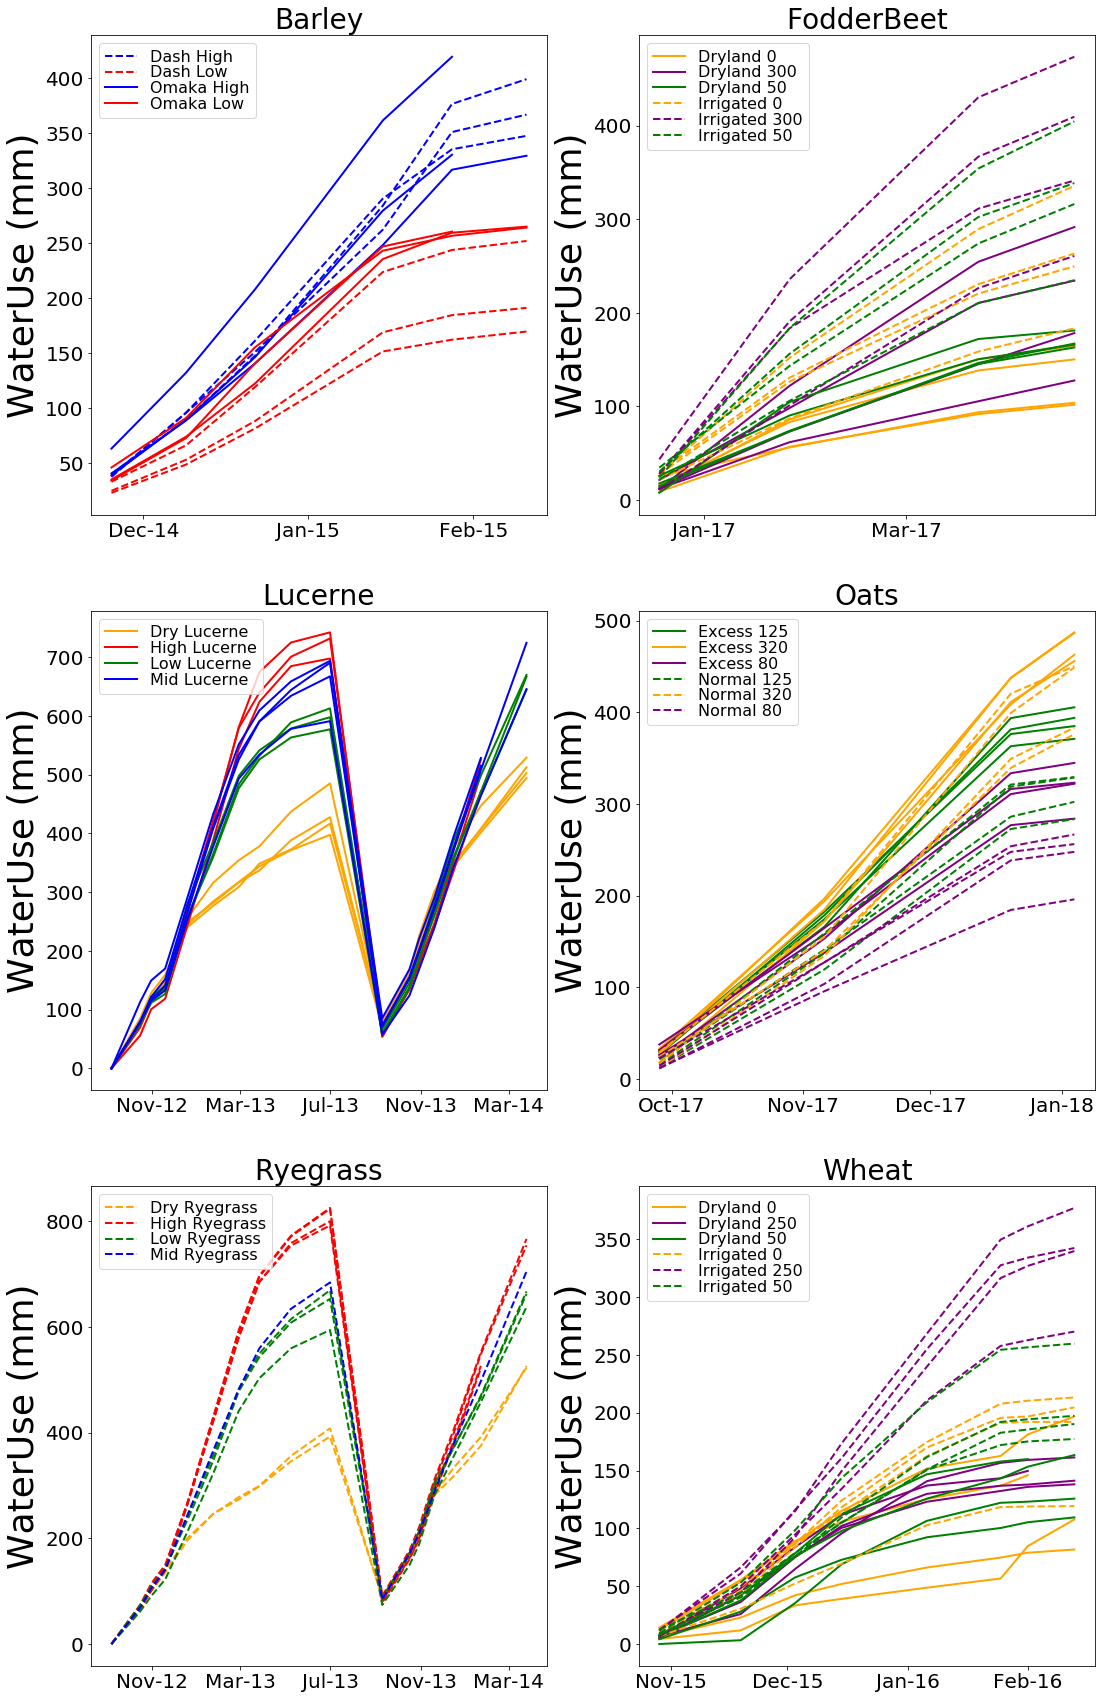

In [18]:
MakeTimeSeriesGraphs(AccumulatedWU,'WaterUse (mm)',None,)

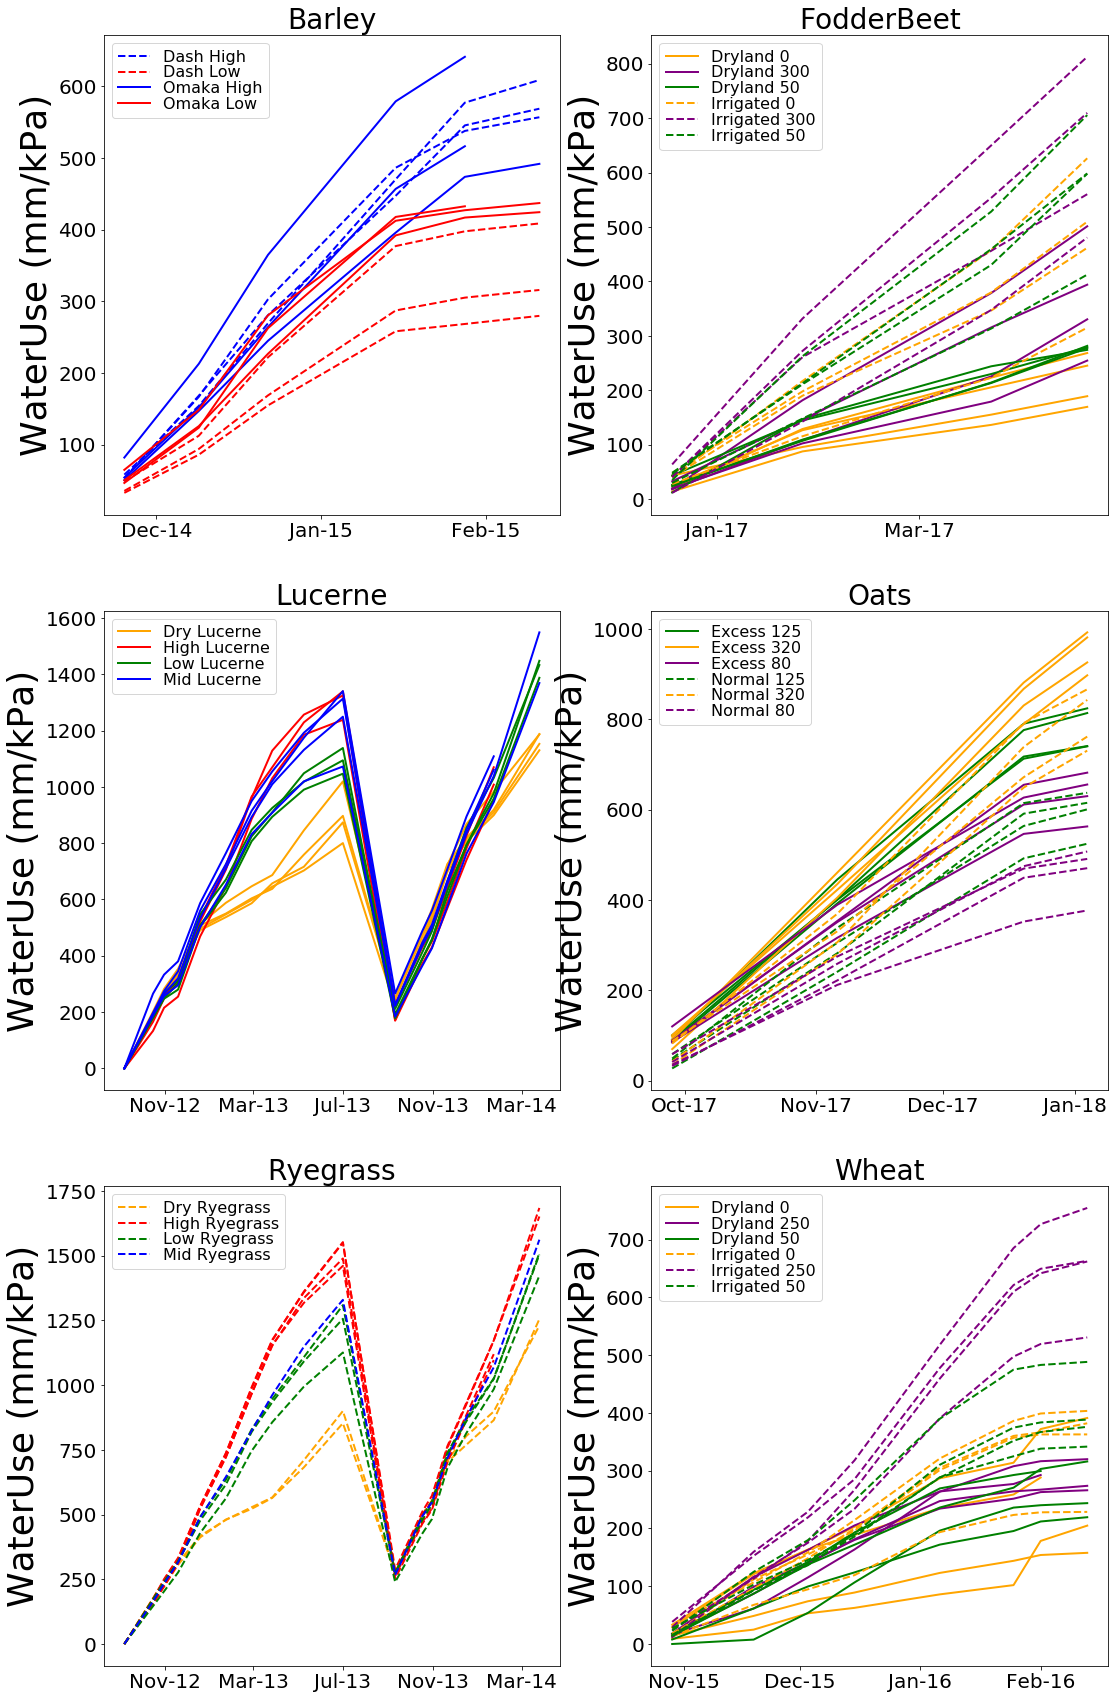

In [19]:
MakeTimeSeriesGraphs(AccumWUoverVPD,'WaterUse (mm/kPa)',None,)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  warnings.warn(message, mplDeprecation, stacklevel=1)


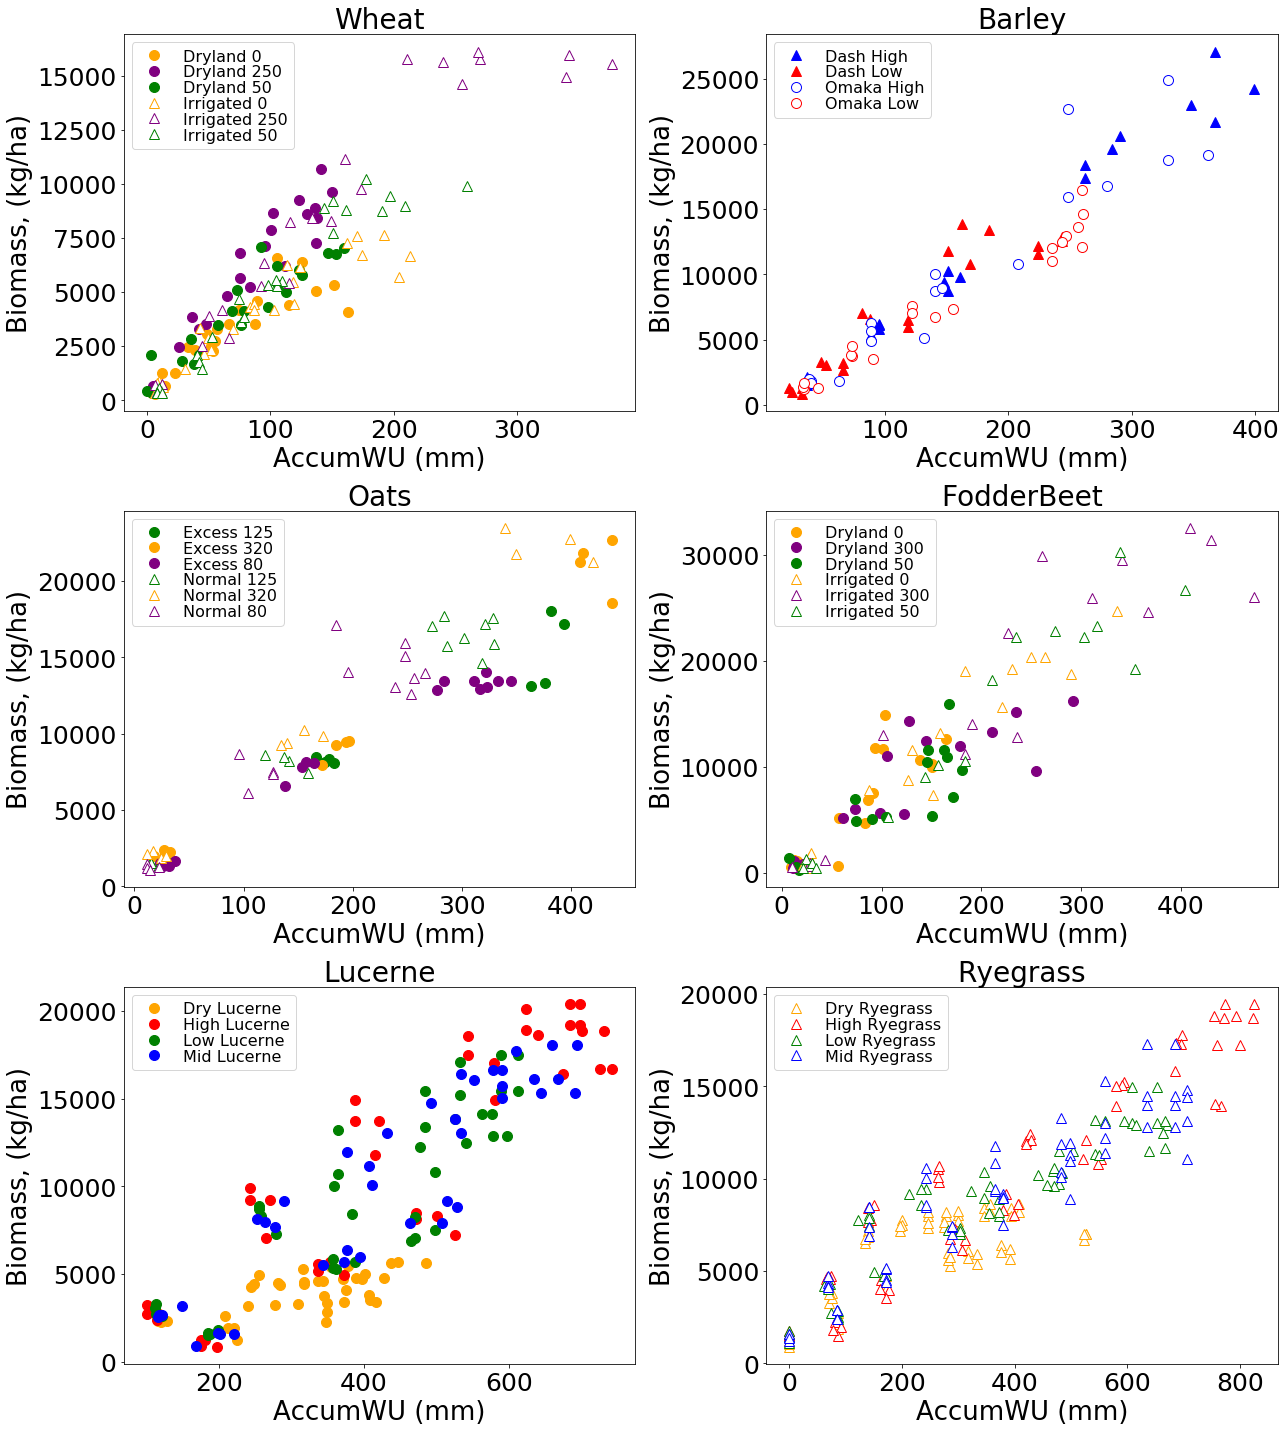

In [20]:
Graph = plt.figure(figsize=(18,20))
pos =  1
for crop in Crops:
        ax = Graph.add_subplot(3,2,pos)
        GH.AddIndexedXY(AccumulatedWU.reindex(Biomass.index).loc[:,crop],
                        Biomass.loc[:,crop],
                        ax,globals()[crop+'GPs'], 10)
        GH.SetAxProps(crop,30,'Biomass, (kg/ha)','AccumWU (mm)',26,25)
        GH.AddLegend(2,16,"")
        plt.title(crop, fontsize=28)
#         Y = MeanPeriodE.loc[:,crop].stack().stack().stack()
#         X = -1 * WU.loc[:,crop].stack().stack().stack().reindex(Y.index)
#         RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
#         Xs = []
#         Xs.append(X.min())
#         Xs.append(X.max())
#         Ys = []
#         Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
#         Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
#         plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
#         fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
#             + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
#             + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
#             + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
#         plt.text(.7,.05,fitR2,fontsize=16,transform=ax.transAxes)
        pos +=1
plt.tight_layout()   

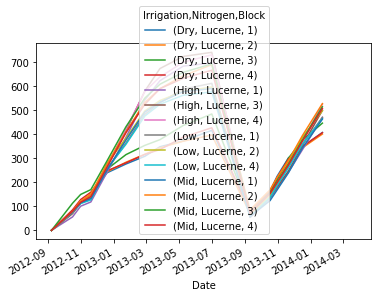

In [21]:
AccumulatedWU.reindex(Biomass.index).loc[:,'Lucerne'].plot()

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  warnings.warn(message, mplDeprecation, stacklevel=1)


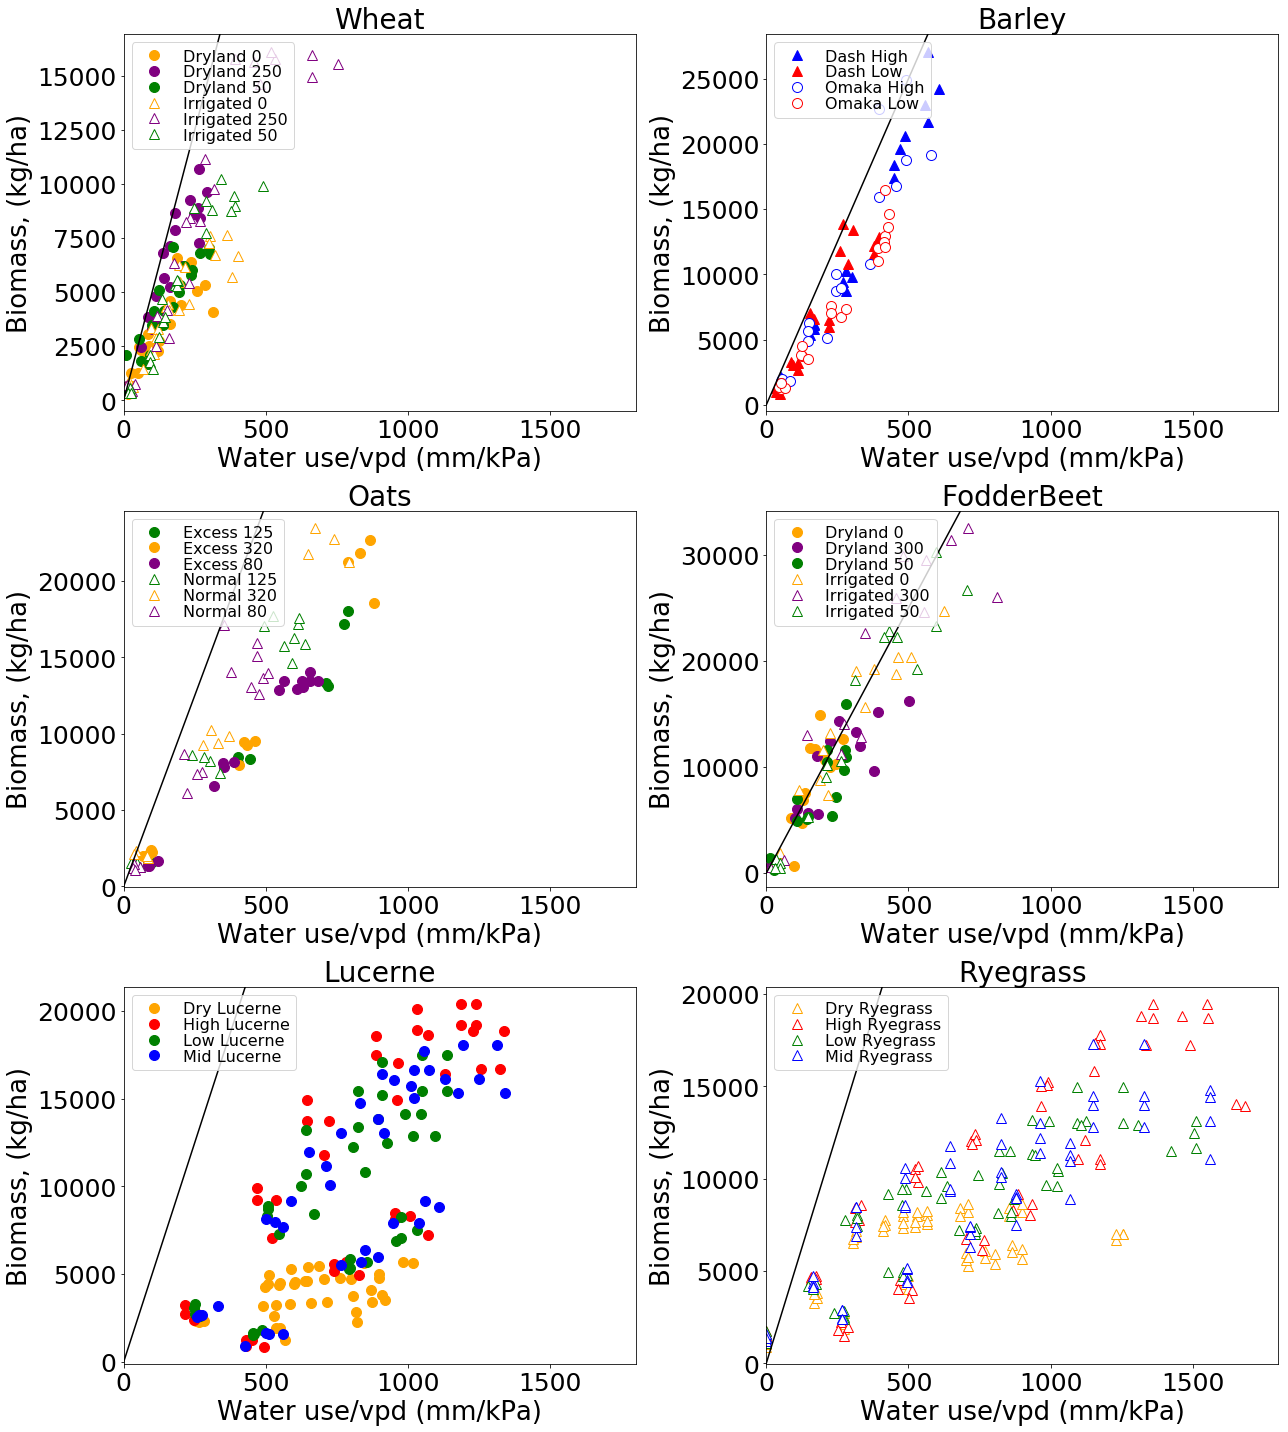

In [22]:
Graph = plt.figure(figsize=(18,20))
pos =  1
for crop in Crops:
        ax = Graph.add_subplot(3,2,pos)
        GH.AddIndexedXY(AccumWUoverVPD.reindex(Biomass.index).loc[:,crop],
                        Biomass.loc[:,crop],
                        ax,globals()[crop+'GPs'], 10)
        GH.SetAxProps(crop,30,'Biomass, (kg/ha)','Water use/vpd (mm/kPa)',26,25)
        GH.AddLegend(2,16,"")
        plt.title(crop, fontsize=28)
        plt.plot([0,1500],[0,75000],'-k')
        plt.xlim([0,1800])
        pos +=1
plt.tight_layout()   

In [23]:
Biomass.Barley.dropna(how='all').loc['2015-01-20':,]

Irrigation          Dash                                            \
Nitrogen            High                                             
Block                  1             2             3             4   
Date                                                                 
2015-01-28           NaN           NaN           NaN           NaN   
2015-02-11  21693.534879  22986.618977  24242.877453  27088.723495   

Irrigation                                                          \
Nitrogen             Low                                             
Block                  1             2             3             4   
Date                                                                 
2015-01-28  12854.833158  13834.351102  13415.222438  12571.368499   
2015-02-11           NaN           NaN           NaN           NaN   

Irrigation                                  ...              Omaka  \
Nitrogen             Mid                    ...               High   
Block                  1             2      ...                  3   
Date                                        ...                      
2015-01-28           NaN           NaN      ...                NaN   
2015-02-11  11894.684205  13735.639486      ...       20164.248777   

Irrigation                                                         \
Nitrogen                          Low                               
Block                  4            1             2             3   
Date                                                                
2015-01-28           NaN  16497.64297  14618.009224  13607.760316   
2015-02-11  24873.236375          NaN           NaN           NaN   

Irrigation                                                          \
Nitrogen                           Mid                               
Block                  4             1             2             3   
Date                                                                 
2015-01-28  12093.890576           NaN           NaN           NaN   
2015-02-11           NaN  12782.375004  13637.248295  14903.967874   

Irrigation                
Nitrogen                  
Block                  4  
Date                      
2015-01-28           NaN  
2015-02-11  14660.533927  

[2 rows x 24 columns]

In [24]:
AccumulatedWU.Barley.dropna(how='all').loc[(pd.to_datetime('2015-01-28'),pd.to_datetime('2015-02-11')),:].max()

Irrigation  Nitrogen  Block
Dash        High      1        366.984031
                      3        347.658805
                      4        399.260643
            Low       1        252.000784
                      3        169.589361
                      4        191.130656
Omaka       High      1        329.557937
                      3        330.498967
                      4        419.612014
            Low       1        265.070999
                      2        260.572102
                      4        264.181543
dtype: float64